![](images/image2.jpg)

# Movie Analysis Project

**Author:** Kai Uechi
***

## Overview

This project is an analysis of movie data to find what types of movies are most profitable. The analysis shows that a film's release month, runtime, and genre correlate to its return on investment. Using this analysis, Microsoft's movie studio can focus on creating animated adventure films between 130-140 minutes long to release in either January or July. These films are likely to be more profitable.

![](images/image3.jpg)

## Business Problem


Microsoft's new movie studio needs to decide on what type of films to create. By analyzing what films are currently performing well, the studio can focus its resources into films that are likely to have the highest return. Using movie data from several sources, I examine how genre, runtime, and time of release affects a film's return on investment.

## Data Understanding

This project uses data from several sources: IMDB (supplying runtime and genre), Box Office Mojo (supplying financial data), and The Numbers (supplying additional financial data, release date, and production budget). Data from The Numbers is particularly useful, as the production budget information allows for a films return on investment to be determined.

In [34]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

%matplotlib inline

In [35]:
# Here you run your code to explore the data
imdb_basic = pd.read_csv('data/title.basics.csv')
imdb_ratings = pd.read_csv('data/title.ratings.csv')
bom_gross = pd.read_csv('data/bom.movie_gross.csv')
tn_budget = pd.read_csv('data/tn.movie_budgets.csv')

### "IMDB" data
Data from IMDB is used to determine a film's genre and runtime.

In [36]:
imdb_basic.head(3)

,tconst,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama


### "Box Office Mojo" data
Data from Box Office Mojo is used for information regarding a film's financial performance.

In [37]:
bom_gross.head(3)

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010


### "The Numbers" data
Data from The Numbers is used to determine a film's production budget.

In [38]:
tn_budget.head(3)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"


## Data Preparation


Data preparation steps are as follows:
* Create a new column using the film title and start year. Then, join the tables on that column.
* Since movie genre and financial performance are critical to this analysis, drop rows missing genre or financial data.
* Clean domestic & foreign gross data and create a total_gross column.
* Remove any duplicate movies
* Create a new column to capture return on investment (roi)
* Expand genres column to columns containing boolean values for each genre category
* To ensure results are not skewed, drop outliers based on financial data.
* Create new column for month of release


**Cleaning**: Create title_year column and join tables

In [39]:

df = imdb_basic
#start with a clean movie title
df.loc[:, 'title_clean'] = (df['primary_title'].str.strip().str.lower())
bom_gross.loc[:, 'title_clean'] = (bom_gross['title'].str.strip().str.lower())
tn_budget.loc[:, 'title_clean'] = (tn_budget['movie'].str.strip().str.lower())

#then add release year

#have to clean tn release date first

def cleanDate(dateStr):
    date = datetime.strptime(dateStr, '%b %d, %Y')
    return str(date.year)


tn_budget.loc[:, 'year_clean'] = tn_budget['release_date'].map(cleanDate)

#create a column to join on

df.loc[:, 'title_year'] = (df['title_clean'] + df['start_year'].astype(str))
bom_gross.loc[:, 'title_year'] = (bom_gross['title_clean'] + bom_gross['year'].astype(str))
tn_budget.loc[:, 'title_year'] = (tn_budget['title_clean'] + tn_budget['year_clean'].astype(str))

#set it as the index
df.set_index('title_year', inplace=True)
bom_gross.set_index('title_year', inplace=True)
tn_budget.set_index('title_year', inplace=True)

In [40]:
#join tables
df = df.join(bom_gross, how='left', rsuffix='_bom')
df = df.join(tn_budget, how='left', rsuffix='_tn')


**Cleaning**: Drop rows missing critical data

In [41]:
#drop rows missing genre data
df.dropna(subset = ['genres'], inplace=True)

#drop rows missing financial data
df.dropna(subset=['domestic_gross_tn', 'domestic_gross'], how='all', inplace=True)
to_drop = df.loc[df['worldwide_gross'].isna() & (~df['domestic_gross'].isnull() & df['foreign_gross'].isnull())].index
df.drop(to_drop, inplace=True)


**Feature Engineering**: Create unified total_gross column

In [42]:
#clean gross data and create total_gross column

df.reset_index(inplace = True)

def cleanGross(gross):
    gross = str(gross)
    gross = gross.replace('$', '').replace(',', '')
    return float(gross)

#use tn table's worldwide_gross over bom's data where available
df.loc[~df['worldwide_gross'].isnull(), 'total_gross'] = df['worldwide_gross'].map(cleanGross)
df['domestic_gross'] = df['domestic_gross'].map(cleanGross)
df['foreign_gross'] = df['foreign_gross'].map(cleanGross)
df.loc[df['total_gross'].isnull(), 'total_gross'] = df['domestic_gross'] + df['foreign_gross']

**Cleaning**: Remove duplicate movies

In [43]:
#remove duplicates using title_year column
df = df[~df[['title_year']].duplicated(keep=False)]
df['title_year'].duplicated().sum()

0

**Feature Engineering**: Create return on investment (roi) column

In [44]:
#create new column, return on investment (roi)

#need to clean this one, too
df['production_budget'] = df['production_budget'].map(cleanGross)

df.loc[~df['production_budget'].isnull(), 'roi'] = df['total_gross'] - df['production_budget']

**Cleaning**: Expand genres column to multiple boolean columns

In [45]:
#get distinct genre categories
distinct_genres_raw = df['genres'].unique()

distinct_genres_clean = set()

for elem in distinct_genres_raw:
    elem = str(elem)
    elem = elem.strip()
    elem = elem.lower()
    genres = elem.split(',')
    for category in genres:
        distinct_genres_clean.add(category)

#add a column for each category containing a boolean value
for category in distinct_genres_clean:
    print(category)
    df.loc[(df['genres'].str.strip().str.lower().str.contains(category)), category] = True
    
#replace NaNs in new columns with false
for category in distinct_genres_clean:
    df[category].fillna(False, inplace=True)
    


war
action
mystery
comedy
sci-fi
horror
thriller
family
romance
animation
adventure
documentary
drama
history
biography
music
crime
western
musical
fantasy
sport


**Cleaning**: Drop financial outliers

In [46]:
#drop outliers on roi and total_gross

def getOutlierRange(col):
    q1 = col.quantile(0.25)
    q3 = col.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - (1.5*iqr)
    upper_bound = q3 + (1.5*iqr)
    
    return (lower_bound, upper_bound)

gross_out = getOutlierRange(df['total_gross'])
df_dropOutliers = df[~( (df['total_gross'] < gross_out[0]) | (df['total_gross'] > gross_out[1]) )]

roi_out = getOutlierRange(df_dropOutliers['roi'])
df_dropOutliers = df_dropOutliers[~( (df_dropOutliers['roi'] < roi_out[0]) | (df_dropOutliers['roi'] > roi_out[1]) )]

#df_dropOutliers

**Feature Engineering**: Create release_month column

In [47]:
#create column for release month
def cleanMonth(dateStr):
    
    date = datetime.strptime(dateStr, '%b %d, %Y')
    return str(date.month)

#assign to new frame 
df_month = df_dropOutliers[~df_dropOutliers['release_date'].isna()]
df_month.loc[:, 'release_month'] = df_month['release_date'].map(cleanMonth)

map_month = {'1': 'Jan', '2': 'Feb', '3': 'Mar', '4': 'Apr', '5': 'May',
                         '6': 'Jun', '7': 'Jul', '8': 'Aug', '9': 'Sep', '10': 'Oct', '11': 'Nov', '12': 'Dec'}
df_month['release_month'] = df_month['release_month'].map(map_month)



C:\Users\Floobledorf\anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Floobledorf\anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
<ipython-input-47-a20cd2e86c9c>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

## Data Analysis


### Genre Vs Return on Investment

Most genres have little correlation with a film's return on investment, but several categories stand out:
* Adventure
* Animation
* Comedy
* Drama

Text(114.0, 0.5, 'Genres')

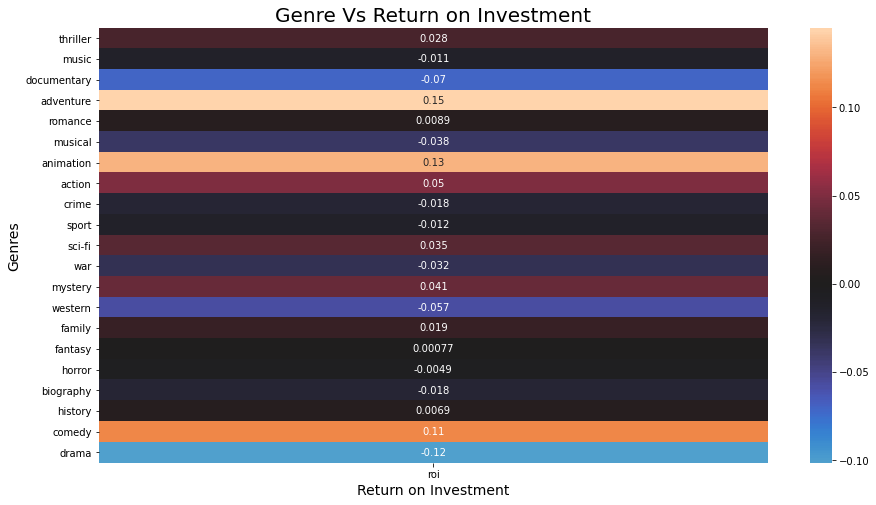

In [48]:

corr_col = ['thriller', 'music', 'documentary', 'adventure', 'romance', 'musical', 'animation', 
            'action', 'crime', 'sport', 'sci-fi', 'war', 'mystery', 'western', 'family', 'fantasy', 
            'horror', 'biography', 'history', 'comedy', 'drama', 
            'roi', 'total_gross']



plt.figure(figsize = (15,8))
df_corr = df_dropOutliers[corr_col].corr()[['roi']]
df_corr.dropna(inplace=True)
df_corr.drop(['roi', 'total_gross'], inplace=True)
ax = sns.heatmap(df_corr, center=0, robust=True, annot=True)
ax.set_title('Genre Vs Return on Investment', fontsize=20)
ax.set_xlabel('Return on Investment', fontsize=14)
ax.set_ylabel('Genres', fontsize=14)

In [49]:
df_dropOutliers.corr()[['roi', 'total_gross']].sort_values('roi', ascending=False)

,roi,total_gross
roi,1.000000,0.862278
total_gross,0.862278,1.000000
domestic_gross,0.794655,0.816595
foreign_gross,0.697086,0.918142
production_budget,0.327233,0.760719
adventure,0.154851,0.355008
runtime_minutes,0.142938,0.189277
animation,0.130321,0.163599
comedy,0.111873,0.081597
id,0.073716,0.035629


### Runtime Vs Return on Investment

Most movies last between 75 to 125 minutes, and longer movies tend to have better returns.
However, this trend stops past the 140 minute mark.

<ipython-input-50-b358c3d48c55>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_runtime['runbins'] = pd.cut(df_dropOutliers['runtime_minutes'], bins).astype(str)


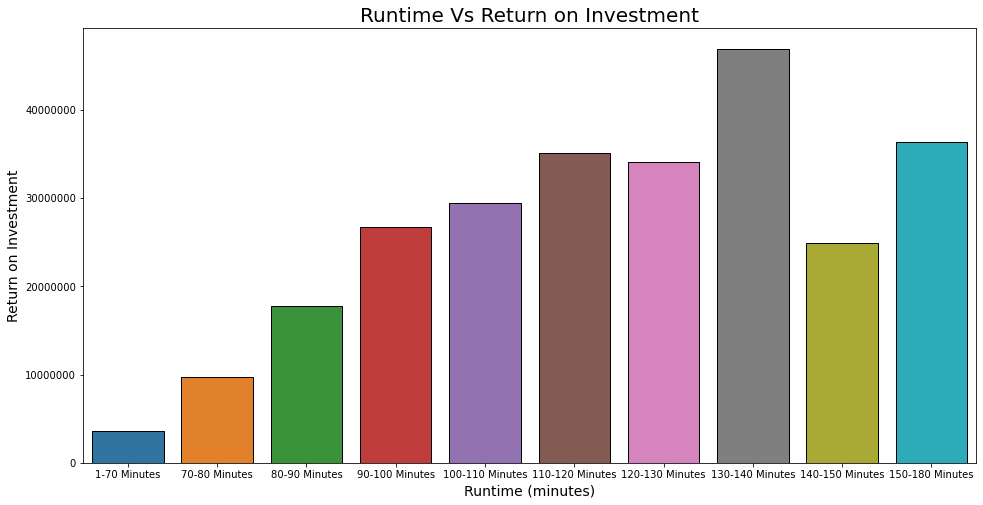

In [50]:
#create bins
bins = [1, 70, 80, 90, 100, 110, 120, 130, 140, 150, 180]

#cut dataframe based on bins
df_runtime = df_dropOutliers[~df_dropOutliers['runtime_minutes'].isna()]
df_runtime['runbins'] = pd.cut(df_dropOutliers['runtime_minutes'], bins).astype(str)

#map bins to readable strings
df_runtime = df_runtime[~(df_runtime['runbins'] == 'nan')]
map_runtime = {'(1.0, 70.0]': '1-70 Minutes', '(70.0, 80.0]': '70-80 Minutes', '(150.0, 180.0]': '150-180 Minutes', 
             '(140.0, 150.0]': '140-150 Minutes', '(130.0, 140.0]': '130-140 Minutes', '(120.0, 130.0]': '120-130 Minutes',
             '(80.0, 90.0]': '80-90 Minutes', '(110.0, 120.0]': '110-120 Minutes', '(100.0, 110.0]': '100-110 Minutes',
             '(90.0, 100.0]': '90-100 Minutes'}
df_runtime['runbins'] = df_runtime['runbins'].map(map_runtime)

#plot
plt.figure(figsize = (16,8))
runtime_order = ['1-70 Minutes', '70-80 Minutes', '80-90 Minutes', '90-100 Minutes', '100-110 Minutes', '110-120 Minutes',
                 '120-130 Minutes', '130-140 Minutes', '140-150 Minutes', '150-180 Minutes']
ax = sns.barplot(x='runbins', y='roi', data=df_runtime, alpha=1, edgecolor='k', ci=None, order=runtime_order)
ax.set_title('Runtime Vs Return on Investment', fontsize=20)
ax.set_xlabel('Runtime (minutes)', fontsize=14)
ax.set_ylabel('Return on Investment', fontsize=14)
ax.ticklabel_format(style='plain', axis='y')

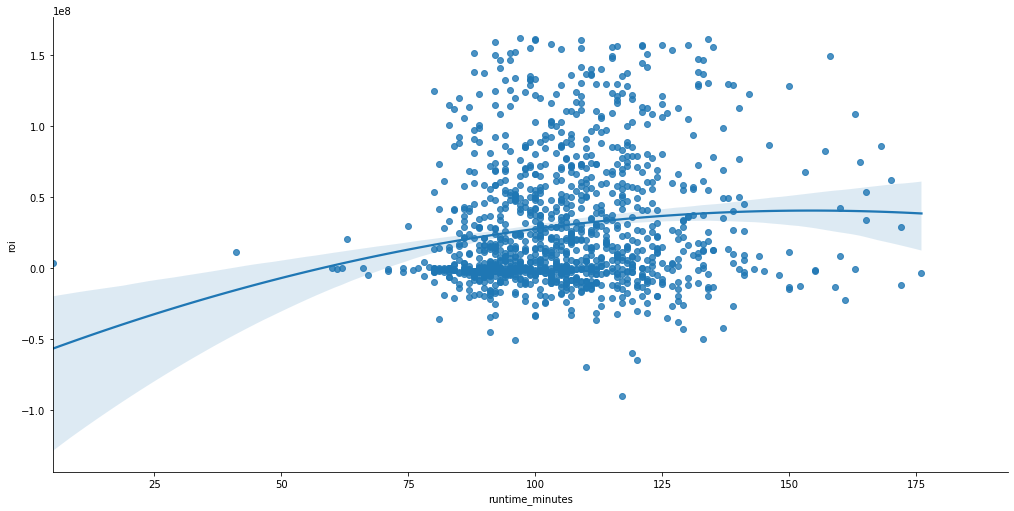

In [51]:
ax = sns.lmplot(x='runtime_minutes', y='roi', data=df_dropOutliers, order=2, height=7, aspect=2)

### Release Month Vs Return on Investment

Most movies tend to release near the end of the year, especially in October and December.
However, the average return on investment is highest in January and July. Both months have significantly fewer releases.

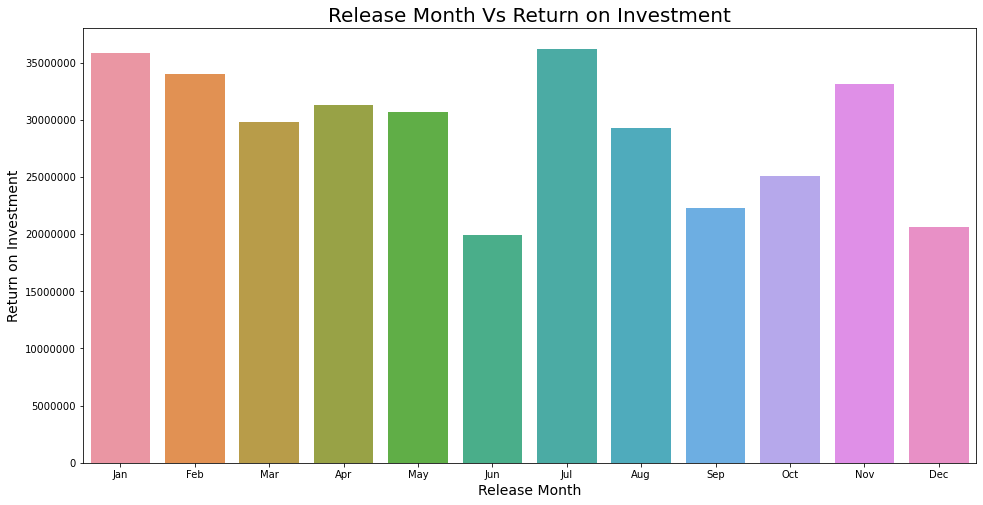

In [52]:
month_avgs = df_month[['roi', 'total_gross', 'release_month']].groupby('release_month').mean()


month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.figure(figsize = (16,8))

ax = sns.barplot(x='release_month', y='roi', data=df_month, ci=None, order=month_order)
ax.set_title('Release Month Vs Return on Investment', fontsize=20)
ax.set_xlabel('Release Month', fontsize=14)
ax.set_ylabel('Return on Investment', fontsize=14)
ax.ticklabel_format(style='plain', axis='y')

In [53]:
month_avgs.round(2)

,roi,total_gross
release_month,,
Apr,31299542.08,55804875.41
Aug,29301372.80,58630645.53
Dec,20616184.12,45161995.81
Feb,33988299.89,70084805.92
Jan,35831668.19,66698763.43
Jul,36214892.26,68929006.84
Jun,19887902.07,47981875.75
Mar,29758409.82,66465736.55
May,30701777.24,68586499.46


In [54]:
df_month['release_month'].value_counts()

Dec    154
Oct    151
Sep    130
Aug    110
Nov    110
Mar    101
Jul     96
Feb     83
Jun     76
Apr     75
May     72
Jan     63
Name: release_month, dtype: int64

## Conclusions

Three main points can be concluded from this analysis:
* **Adventure, Animation, and Comedy films should be prioritized.** Additionally, Drama and Documentary films should be avoided. Genres besides these have little impact on a film's return on investment.
* **Films should aim to have a runtime of between 130-140 minutes.** A runtime longer than 140 minutes is likely to be a detriment.
* **Films should prioritize releasing in January or July.** Films should also avoid releasing in June, September, October, or December. 


### Next Steps

The following steps are likely to expand and improve upon this analysis:
* **Gather more data, especially regarding a film's production budget.** This analysis was performed on a comparatively small set of movies due to a lack of data on production budget. More data will improve the accuracy of findings.
* **Group results by year to predict trends.** By grouping the performance of specific genres or release months to each year, results will not be skewed by old trends. (For instance, a genre that was very popular several years ago, but is no longer profitable.)